# Импорт библиотек

In [46]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imbl
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Загрузка данных

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/train_data_0.pq')

In [4]:
# Вывод размерности
print(f'Датасет имеет размерность: {data.shape}')

Датасет имеет размерность: (1974724, 61)


In [5]:
data

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,249998,4,1,9,14,8,10,11,8,4,...,3,3,3,4,1,2,3,1,0,1
1974720,249998,5,7,9,4,8,1,11,19,1,...,3,3,3,4,1,2,4,1,1,1
1974721,249999,1,9,0,10,8,10,11,16,2,...,3,3,3,4,1,2,3,1,0,1
1974722,249999,2,9,16,10,13,10,4,12,2,...,3,3,3,4,1,2,3,1,0,0


# DataPreparation

## Обработка пропущенных значений

In [6]:
print(f'Количество пропусков в признаках:')
(data.isna().sum()).sort_values(ascending=False)

Количество пропусков в признаках:


id                    0
enc_paym_1            0
enc_paym_3            0
enc_paym_4            0
enc_paym_5            0
                     ..
pre_over2limit        0
pre_maxover2limit     0
is_zero_util          0
is_zero_over2limit    0
fclose_flag           0
Length: 61, dtype: int64

***В данных нет пропусков***

## Проверка линейной коррелиции между признаками

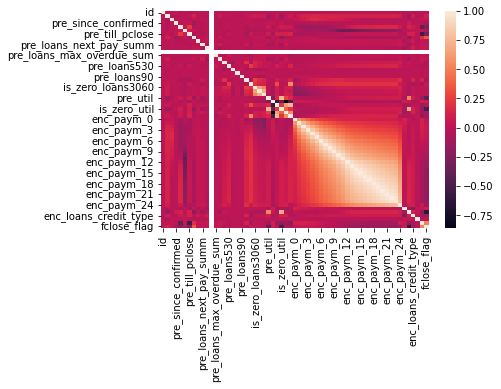

In [7]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix);

In [8]:
high_corr_features = ((corr_matrix>0.7).sum()-1)
high_corr_features[high_corr_features>0]

pre_util                  1
pre_maxover2limit         1
is_zero_util              1
is_zero_maxover2limit     1
enc_paym_1                1
enc_paym_2                2
enc_paym_3                3
enc_paym_4                3
enc_paym_5                4
enc_paym_6                5
enc_paym_7                5
enc_paym_8                5
enc_paym_9                6
enc_paym_10               7
enc_paym_11               9
enc_paym_12              11
enc_paym_13              12
enc_paym_14              13
enc_paym_15              12
enc_paym_16              12
enc_paym_17              12
enc_paym_18              11
enc_paym_19              11
enc_paym_20              12
enc_paym_21              11
enc_paym_22              11
enc_paym_23              10
enc_paym_24               4
dtype: int64

***Видно что в области признаков enc_paym наблюдаются высокие корреляции. Вместо всех таких признаков будет использоваться один сагрегированный признак (мода)***

In [9]:
# Сагрегируем признаки enc_paym_* в один признак enc_paym, в качестве агрегирующей функции используем моду
features_enc = [i for i in data.columns if i.startswith('enc_paym_')]
data['enc_paym'] = data[features_enc].apply(lambda d: d.mode()[0], axis=1)
data.drop(columns=features_enc, inplace=True)

## Агрегация данных

В датасете одному и тому же id сответсвует несколько записей, необходимо сагрегировать датасет так, чтобы одному id соответствовала одна запись.

Стратегия агрегации:
1. Датасет кодируется корячим кодированием
2. Происходит агрегация датасета по id с агрегирующей функцией - суммой.

Таким образом, будет видно сколько раз определенная категория какого-либо признака встречалась в истории клиента.

In [10]:
ohe = OneHotEncoder(sparse=False)

In [11]:
rn_feat = data.groupby(['id'], as_index=False)['rn'].max()
data.drop(columns=['rn'], inplace=True)

In [ ]:
agg_feat = data.drop(columns=['id']).columns
ohe.fit(data[agg_feat])
data[ohe.get_feature_names_out()] = ohe.transform(data[agg_feat])
data.drop(columns=agg_feat, inplace=True)
data = data.groupby(['id'], as_index=False).sum()

In [20]:
data = pd.merge(data, rn_feat, on='id')

targets = pd.read_csv(f'data/train_target.csv')
data = pd.merge(data, targets, on='id')
del targets

In [21]:
data.drop(columns=['id'], inplace=True)

## Баланс классов

In [23]:
print('Процентное соотношение классов:')
data['flag'].value_counts()/len(data)*100

Процентное соотношение классов:


0    96.9064
1     3.0936
Name: flag, dtype: float64

***В выбоке присутсвует сильный дисбаланс классов***

## Отбор признаков

In [24]:
s = SelectKBest()
s.fit(data.drop(columns=['flag']), data['flag'])
scores = list(zip(data.drop(columns=['flag']), s.scores_))

In [25]:
init_features = ['rn'] + list(ohe.feature_names_in_)

In [26]:
di = {}
for feat in init_features:
    di[feat] = np.nanmean([d[1] for d in scores if d[0].startswith(feat+'_')])
di['rn'] = np.nanmean([d[1] for d in scores if d[0]=='rn'])

In [27]:
di = dict(sorted(di.items(), key=lambda d: d[1]))

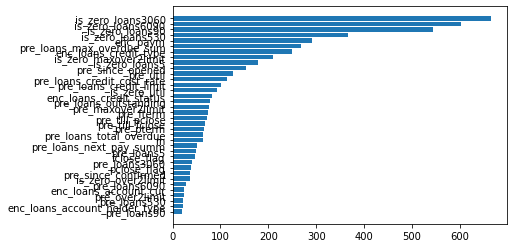

In [28]:
plt.barh(list(di), list(di.values()));

In [29]:
features = list(di.keys())[-20:] # Будем использовать изначальных признаков 20 признаков
final_features = [feat for feat in data.columns if any([feat.startswith(f+'_') for f in features])]

# Modeling

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    data[final_features],
    data['flag'],
    test_size=0.3,
    stratify=data['flag'],
    random_state=42
)

pos_weight = (y_train==0).sum() / (y_train==1).sum()

Построим модели машинного обучения, при этом с дисбалансом классов будем бороться либо с помощью взвешивания классов, либо с помощью генерации синтетических объектов минорного класса

### LogisticRegression

In [32]:
# Взвешивание классов
logreg = LogisticRegression(class_weight='balanced', random_state=42)

pipe = Pipeline(steps=(
    ('std', StandardScaler()),
    ('model', logreg)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для LogisticRegression на train: 0.7567830591948401
roc_auc для LogisticRegression на test: 0.7431722607841649


In [33]:
# Генерация объектов минорнорного класса
logreg = LogisticRegression(random_state=42)

pipe = Pipeline_imbl(steps=(
    ('std', StandardScaler()),
    ('smt', SMOTE()),
    ('model', logreg)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для LogisticRegression на train: 0.7458748194624436
roc_auc для LogisticRegression на test: 0.730161892945932


### RandomForest

In [34]:
# Взвешивание классов
rfc = RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42)

pipe = Pipeline(steps=(
    ('preprocessor', StandardScaler()),
    ('model', rfc)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для RandomForestClassifier на train: 0.7684706289727035
roc_auc для RandomForestClassifier на test: 0.7341966793501984


In [35]:
# Генерация объектов минорнорного класса
rfc = RandomForestClassifier(max_depth=6, random_state=42)

pipe = Pipeline_imbl(steps=(
    ('std', StandardScaler()),
    ('smt', SMOTE()),
    ('model', rfc)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для RandomForestClassifier на train: 0.7442667370949582
roc_auc для RandomForestClassifier на test: 0.7177879622293284


### XGBoost

In [36]:
# Взвешивание классов
xgb = XGBClassifier(scale_pos_weight=pos_weight, random_state=42, max_depth=2)

pipe = Pipeline(steps=(
    ('preprocessor', StandardScaler()),
    ('model', xgb)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для XGBClassifier на train: 0.7837930916583049
roc_auc для XGBClassifier на test: 0.7530066167470062


In [37]:
# Генерация объектов минорнорного класса
xgb = XGBClassifier(scale_pos_weight=pos_weight, random_state=42, max_depth=2)

pipe = Pipeline_imbl(steps=(
    ('std', StandardScaler()),
    ('smt', SMOTE()),
    ('model', xgb)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для XGBClassifier на train: 0.736156616828193
roc_auc для XGBClassifier на test: 0.7121623187615053


### CatBoost

In [38]:
# Взвешивание классов
cat = CatBoostClassifier(iterations=150, depth=3, random_state=42, verbose=False)

pipe = Pipeline(steps=(
    ('preprocessor', StandardScaler()),
    ('model', cat)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для CatBoostClassifier на train: 0.783500072174288
roc_auc для CatBoostClassifier на test: 0.748265450937506


In [39]:
# Генерация объектов минорнорного класса
cat = CatBoostClassifier(iterations=150, depth=3, random_state=42, verbose=False)

pipe = Pipeline_imbl(steps=(
    ('std', StandardScaler()),
    ('smt', SMOTE()),
    ('model', cat)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для CatBoostClassifier на train: 0.7741210835744359
roc_auc для CatBoostClassifier на test: 0.738346806620424


### AdaBoost

In [40]:
# Взвешивание классов
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
    n_estimators=200,
    random_state=42
)

pipe = Pipeline(steps=(
    ('preprocessor', StandardScaler()),
    ('model', ada)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для AdaBoostClassifier на train: 0.7751085466830017
roc_auc для AdaBoostClassifier на test: 0.7478612048801548


In [41]:
# Генерация объектов минорнорного класса
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
    n_estimators=100,
    random_state=42
)

pipe = Pipeline_imbl(steps=(
    ('std', StandardScaler()),
    ('smt', SMOTE()),
    ('model', ada)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для AdaBoostClassifier на train: 0.7139594355843032
roc_auc для AdaBoostClassifier на test: 0.6973197222591236


Все модели показывают лучший результат, без использования синтетических объектов минорного класса. Далее рассматривается модель голосования, созданная из моделей рассмотренных выше.

### VOTING

In [44]:
models = [
    ('logreg', LogisticRegression(class_weight='balanced', random_state=42)),
    ('rfc', RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42))
]

vote = VotingClassifier(models, voting='soft')

pipe = Pipeline(steps=(
    ('std', StandardScaler()),
    ('model', vote)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для VotingClassifier на train: 0.7729457136517484
roc_auc для VotingClassifier на test: 0.7518675927068112


In [45]:
models = [
    ('logreg', LogisticRegression(class_weight='balanced', random_state=42)),
    ('rfc', RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=pos_weight, random_state=42, max_depth=2))
]

vote = VotingClassifier(models, voting='soft')

pipe = Pipeline(steps=(
    ('std', StandardScaler()),
    ('model', vote)
))
pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на train: {roc_auc_score(y_train, y_train_proba)}')
print(f'roc_auc для {type(pipe.named_steps["model"]).__name__} на test: {roc_auc_score(y_test, y_test_proba)}')

roc_auc для VotingClassifier на train: 0.78101456182753
roc_auc для VotingClassifier на test: 0.7558883354999715


# Вывод

Лучшую метрику для данной задачи показывает модель VotingClassifier, построенная на моеделях LogisticRegression, RandomForestClassifier и XGBoostClassifier

In [48]:
best_pipe = Pipeline(steps=(
    ('std', StandardScaler()),
    ('model', vote)
))
best_pipe.fit(data[final_features], data['flag'])

with open('best_pipe.pkl', 'wb') as file:
    dill.dump(best_pipe, file)